# Data Exploration

**Purpose of script:**

Load the microwave data (netCDF) and optical data (tif) investigate data properties and create some first plots

- In: mw netCDF data, opt tif data, elevation tif data

Imports

In [48]:
import os
import pandas as pd
import numpy as np
import numpy.ma as ma
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import datetime as dt

from netCDF4 import Dataset
import xarray as xr
import rioxarray
import rasterio
import matplotlib.pyplot as plt

## Microwave Data

Relevant path:

In [19]:
microwave_path = r"..\..\Data\microwave-rs\CumJour-North-ssmi-1979-2022-H19.nc"

Data load

In [29]:
data_mw = xr.open_dataset(microwave_path)
data_mw

<xarray.Dataset>
Dimensions:      (y: 109, x: 60, time: 15663, nv: 4)
Coordinates:
  * time         (time) datetime64[ns] 1979-11-01 1979-11-02 ... 2022-10-30
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
Dimensions without coordinates: nv
Data variables:
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
    bounds_lat   (y, x, nv) float32 ...
    bounds_lon   (y, x, nv) float32 ...
    spatial_ref  int64 ...
    melt         (time, y, x) float32 ...

In [21]:
print(data_mw.dims)
print(data_mw.attrs)
print(data_mw.coords)

Frozen({'y': 109, 'x': 60, 'time': 15663, 'nv': 4})
{}
Coordinates:
  * time     (time) datetime64[ns] 1979-11-01 1979-11-02 ... 2022-10-30
  * x        (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 7.75e+05 8e+05 8.25e+05
  * y        (y) float64 -6.25e+05 -6.5e+05 -6.75e+05 ... -3.3e+06 -3.325e+06


In [67]:
data_mw.spatial_ref.crs_wkt

'PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","3413"]]'

DATA VARIABLES IN NETCDF FILE:
- dimensions(sizes): y(109), x(60), time(15663), nv(4)
- variables(dimensions): 
- float32 lat(y, x), 
- float32 lon(y, x), 
- int64 time(time), 
- float32 bounds_lat(y, x, nv), 
- float32 bounds_lon(y, x, nv), 
- float64 x(x), 
- float64 y(y), 
- int64 spatial_ref(), 
- int8 melt(time, y, x)

DIMENSIONS:
- x and y - projected (cartesian) coordinate system
- time - number of days
- nv - 4 corners of pixel

Filter for June/July 2019

In [22]:
# storing full latitude and longitude values for visualization
lat = data_mw.variables['lat'][:]
lon = data_mw.variables['lon'][:]

bottom_filter = np.datetime64('2019-06-01')
top_filter = np.datetime64('2019-07-31')
data_mw = data_mw.where((bottom_filter <= data_mw["time"]) & (data_mw["time"] <= top_filter), drop=True)
data_mw

<xarray.Dataset>
Dimensions:      (y: 109, x: 60, time: 61, nv: 4)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-01 2019-06-02 ... 2019-07-31
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
Dimensions without coordinates: nv
Data variables:
    lat          (y, x, time) float32 81.69 81.69 81.69 ... 58.99 58.99 58.99
    lon          (y, x, time) float32 -90.0 -90.0 -90.0 ... -30.91 -30.91 -30.91
    bounds_lat   (y, x, nv, time) float32 81.69 81.69 81.69 ... 58.91 58.91
    bounds_lon   (y, x, nv, time) float32 -91.12 -91.12 -91.12 ... -31.17 -31.17
    spatial_ref  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    melt         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

First plots

In [30]:
melt_nc = data_mw.variables['melt'][:]
time_nc = data_mw.variables['time'][:]

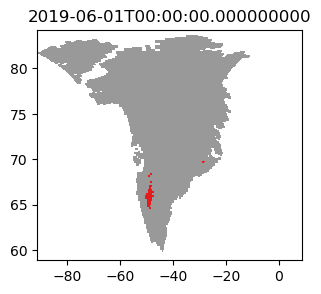

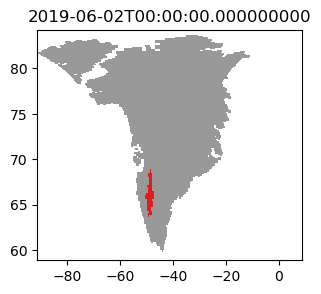

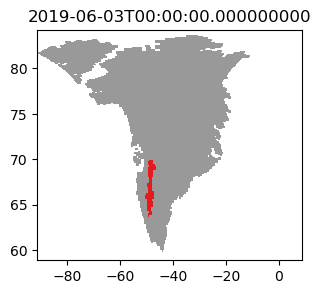

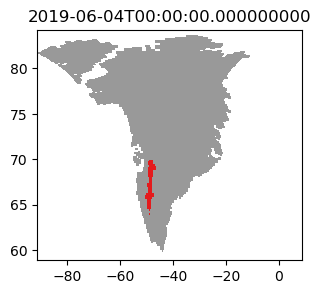

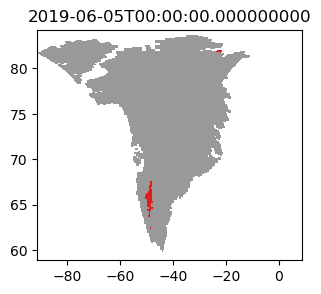

In [10]:
for i in range(5):
    fig, axs = plt.subplots(figsize=(3, 3),  nrows=2, ncols=1,gridspec_kw={'height_ratios': [20,1.5]},constrained_layout=True) #
    plot = axs[0].pcolormesh(lon, lat, np.ma.getdata(melt_nc[i]), cmap='Set1_r') # 'viridis'
    axs[0].set_title(time_nc.values[i])
    cbar=fig.colorbar(plot, cax=axs[1], extend='both', orientation='horizontal')
    cbar.remove()

## Optical data

Relevant paths

In [13]:
opt_dir_path = r"../Data/optical-rs"
optical_path = r'../Data/optical-rs/2019-06-08_grain_diameter.tif'

Data load

In [14]:
tfs_opt = [os.path.join(opt_dir_path, f) for f in os.listdir(opt_dir_path) if f.endswith(".tif")]	
data_opt = []
for f in tfs_opt:
    data_opt.append(rioxarray.open_rasterio(f, masked=True))

Asserting that all files have the same metadata

In [15]:
Y = 2687
X = 1487
resolution = (1000.0, -1000.0)
bounds = (-637000, -3349000, 850000, -662000)
CRS = "EPSG:3413"

for d in data_opt:
    assert d.rio.shape[0] == Y
    assert d.rio.shape[1] == X
    assert d.rio.resolution() == resolution
    assert d.rio.bounds() == bounds
    assert d.rio.crs == CRS

Load one file to test

In [21]:
data_opt = rioxarray.open_rasterio(optical_path)
data_opt 

<xarray.DataArray (band: 1, y: 2687, x: 1487)>
[3995569 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -6.365e+05 -6.355e+05 ... 8.485e+05 8.495e+05
  * y            (y) float64 -6.625e+05 -6.635e+05 ... -3.348e+06 -3.348e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
with rasterio.open(optical_path) as dataset_opt:
    print(dataset_opt.crs)

EPSG:3413


Test on how to read band array values

In [23]:
band_id = 1  

raster = rasterio.open(optical_path) #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)
np.unique(band_arr)

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

First plots

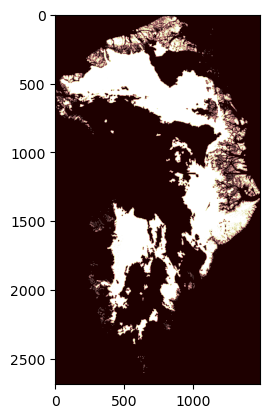

In [24]:
src = rasterio.open(optical_path)
plt.imshow(src.read(1), cmap='pink')
plt.show()

## Elevation Data

In [4]:
elevation_path = r"../../Data/elevation_data/gimpdem_1km_compressed.tif"

data_elevation = rioxarray.open_rasterio(elevation_path)
data_elevation 

<xarray.DataArray (band: 1, y: 2687, x: 1487)>
[3995569 values with dtype=int16]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -6.365e+05 -6.355e+05 ... 8.485e+05 8.495e+05
  * y            (y) float64 -6.625e+05 -6.635e+05 ... -3.348e+06 -3.348e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## Weather Station Data

X: 377584

Y: -1037404

In [141]:
start_date = np.datetime64("2019-06-08")
end_date = np.datetime64("2019-08-01")

surface_path = r"../../Data/weatherstation_data/KPC_U_surface.nc"
slwc_path = r"../../Data/weatherstation_data/KPC_U_slwc.nc"

In [132]:
dataset_surface = xr.open_dataset(surface_path).rio.write_crs("epsg:3413", inplace=True)
dataset_slwc = xr.open_dataset(slwc_path).rio.write_crs("epsg:3413", inplace=True)

In [159]:
df_surface = pd.DataFrame()

dataset_surface_day = dataset_surface.where((start_date <= dataset_surface["time"]) & (dataset_surface["time"] < end_date), drop=True)
df_surface_day = dataset_surface_day.to_dataframe()[["meltflux", "melt_mweq", "snowfall", "SRin", "SRout", "theta_2m"]]
df_surface = pd.concat([df_surface, df_surface_day], axis=0)

df_surface.head()

,meltflux,melt_mweq,snowfall,SRin,SRout,theta_2m
time,,,,,,
2019-06-08 00:00:00.000000000,0.0,0.0,0.0,198.2,152.9,269.128586
2019-06-08 01:00:00.000006656,0.0,0.0,0.0,231.2,176.8,268.574214
2019-06-08 02:00:00.000003584,0.0,0.0,0.0,211.3,169.6,267.457698
2019-06-08 03:00:00.000000000,0.0,0.0,0.0,186.8,162.8,267.336333
2019-06-08 04:00:00.000006656,0.0,0.0,0.0,165.1,143.6,268.375082


In [160]:
df_surface = df_surface.groupby(df_surface.index.date).mean()
df_surface.index.name = "date"
df_surface

,meltflux,melt_mweq,snowfall,SRin,SRout,theta_2m
date,,,,,,
2019-06-08,0.000000,0.000000,0.0,362.491667,305.104167,272.131334
2019-06-09,0.000000,0.000000,0.0,279.168421,248.616667,271.582798
2019-06-10,0.000000,0.000000,0.0,399.050000,328.481250,271.307287
2019-06-11,1.064209,0.000011,0.0,403.304167,332.022917,272.081193
2019-06-12,3.504696,0.000038,0.0,405.366667,330.600000,272.444182
2019-06-13,73.799187,0.000796,0.0,401.329167,311.291667,277.749584
2019-06-14,87.847219,0.000947,0.0,406.841667,305.045833,277.783961
2019-06-15,74.779628,0.000806,0.0,387.566667,286.862500,276.985721
2019-06-16,43.565981,0.000470,0.0,382.833333,287.066667,275.738513


In [161]:
df_slwc = pd.DataFrame()

dataset_slwc_day = dataset_slwc.where((start_date <= dataset_slwc["time"]) & (dataset_slwc["time"] < end_date) & (dataset_slwc["level"] == 1), drop=True)
df_slwc_day = dataset_slwc_day.to_dataframe()[["slwc", "Depth"]]
df_slwc = pd.concat([df_slwc, df_slwc_day], axis=0).reset_index("level")

df_slwc.head()

,level,slwc,Depth
time,,,
2019-06-08 00:00:00.000000000,1.0,0.0,0.235261
2019-06-08 01:00:00.000006656,1.0,0.0,0.235254
2019-06-08 02:00:00.000003584,1.0,0.0,0.235252
2019-06-08 03:00:00.000000000,1.0,0.0,0.235249
2019-06-08 04:00:00.000006656,1.0,0.0,0.235247


In [162]:
df_slwc = df_slwc.groupby(df_slwc.index.date).mean()
df_slwc.index.name = "date"
df_slwc

,level,slwc,Depth
date,,,
2019-06-08,1.0,0.000000,0.234911
2019-06-09,1.0,0.000000,0.233483
2019-06-10,1.0,0.000000,0.232470
2019-06-11,1.0,0.000016,0.231029
2019-06-12,1.0,0.000155,0.228307
2019-06-13,1.0,0.003154,0.210414
2019-06-14,1.0,0.009967,0.203467
2019-06-15,1.0,0.009937,0.229745
2019-06-16,1.0,0.006444,0.182927


# Check agreement between Weather Station Data and MW and OPT

In [168]:
path_dataframe_plain = r"../../Data/combined/dataframe_plain/"
df_plain = pd.read_parquet(path_dataframe_plain + "melt_2019-06-08.parquet.gzip")


station_coords = (377584, -1037404)
# create list of tuples from data frame columns x and y
points = list(zip(df_plain.x, df_plain.y))
# find tuple closest to tuple coords
closest_point = min(points, key=lambda x: abs(x[0] - station_coords[0]) + abs(x[1] - station_coords[1]))


df_plain_closest = pd.DataFrame()

for f in os.listdir(path_dataframe_plain):
    df_plain = pd.read_parquet(path_dataframe_plain + f)
    df_plain["date"] = f[5:15]
    df_plain_closest = pd.concat([df_plain_closest, df_plain.loc[(df_plain['x'] == closest_point[0]) & (df_plain['y'] == closest_point[1])]], axis=0)

# set column date as index
df_plain_closest = df_plain_closest.set_index("date")
# index as datetime
df_plain_closest.index = pd.to_datetime(df_plain_closest.index)
df_plain_closest.head()

,x,y,mw_value,opt_value
date,,,,
2019-06-08,377500.0,-1037500.0,0.0,-1.000000
2019-06-10,377500.0,-1037500.0,0.0,0.317062
2019-06-11,377500.0,-1037500.0,0.0,0.319171
2019-06-12,377500.0,-1037500.0,1.0,1.349874
2019-06-13,377500.0,-1037500.0,1.0,1.626292


In [173]:
# merge dataframes df_surface onto df_plain_closest based on index
df = df_plain_closest.merge(df_surface, left_index=True, right_index=True, how="left")
df = df.merge(df_slwc, left_index=True, right_index=True, how="left")
df[["mw_value", "slwc", "opt_value", "meltflux"]]

,mw_value,slwc,opt_value,meltflux
date,,,,
2019-06-08,0.0,0.000000,-1.000000,0.000000
2019-06-10,0.0,0.000000,0.317062,0.000000
2019-06-11,0.0,0.000016,0.319171,1.064209
2019-06-12,1.0,0.000155,1.349874,3.504696
2019-06-13,1.0,0.003154,1.626292,73.799187
2019-06-14,1.0,0.009967,1.738999,87.847219
2019-06-15,1.0,0.009937,1.335080,74.779628
2019-06-16,1.0,0.006444,-1.000000,43.565981
2019-06-17,1.0,0.006446,0.787383,35.756928
